In [539]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [540]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [541]:
print(data.head())
print(data.describe(include="all"))
print(data.info(verbose=1))

   id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        N

In [542]:
# create backup of data
original = data.copy()

In [543]:
data['circle_id'].unique()
data['loc_og_t2o_mou'].unique()
data['std_og_t2o_mou'].unique()
data['loc_ic_t2o_mou'].unique()
data['std_og_t2c_mou_6'].unique()
data['std_og_t2c_mou_7'].unique()
data['std_og_t2c_mou_8'].unique()
data['std_ic_t2o_mou_6'].unique()
data['std_ic_t2o_mou_7'].unique()
data['std_ic_t2o_mou_8'].unique()

array([ 0., nan])

In [544]:
unwantedcols=['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8']

In [545]:
data.drop(labels=unwantedcols,axis=1,inplace=True)
unseen.drop(labels=unwantedcols,axis=1,inplace=True)
print(data.shape)
print(unseen.shape)


(69999, 159)
(30000, 158)


In [546]:
# create column name list by types of columns
id_cols = [ 'circle_id']

date_cols = [        
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8',
            
            ]

cat_cols =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8',
             ]

num_cols = [column for column in data.columns if column not in id_cols + date_cols + cat_cols]

# print the number of columns in each list
print("#ID cols: %d\n#Date cols:%d\n#Numeric cols:%d\n#Category cols:%d" % (len(id_cols), len(date_cols), len(num_cols), len(cat_cols)))

# check if we have missed any column or not
print(len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols) == data.shape[1])
#

#ID cols: 1
#Date cols:6
#Numeric cols:147
#Category cols:6
False


#  Handling missing values

# impute missing values

i) Imputing with zeroes

In [547]:
# some recharge columns have minimum value of 1 while some don't
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 
                 ]
data[recharge_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,2.467612,2.679989,2.652441,1.865323,2.056311,2.016018,0.602288,0.623678,0.636423,126.500000,126.402071,125.374925,192.831096,201.455940,196.815792
std,2.794610,3.073472,3.101265,2.566377,2.799916,2.728246,1.279297,1.401230,1.457058,109.352573,109.459266,109.648799,190.623115,198.346141,192.280532
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,82.000000,92.000000,84.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,154.000000,154.000000,154.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,42.000000,48.000000,44.000000,29.000000,34.000000,45.000000,1555.000000,1555.000000,1555.000000,5920.000000,4365.000000,4076.000000


In [548]:
# It is also observed that the recharge date and the recharge value are missing together which means the customer didn't recharge
data.loc[data.total_rech_data_6.isnull() & data.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(20)

,total_rech_data_6,date_of_last_rech_data_6
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN
8,NaN,NaN
9,NaN,NaN
11,NaN,NaN
12,NaN,NaN


In the recharge variables where minumum value is 1, we can impute missing values with zeroes since it means customer didn't recharge their numbere that month.

In [549]:
#impute missing values# Let us first extract list of columns containing recharge amount
amt_recharge_columns =  data.columns[data.columns.str.contains('rech_amt|rech_data')]
print(amt_recharge_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8'],
      dtype='object')


In [550]:
#In the recharge variables where minumum value is 1, we can impute missing values with zeroes since it means customer didn't recharge their numbere that month.

# create a list of recharge columns where we will impute missing values with zeroes
zero_impute = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8'
       ]

In [551]:
# impute missing values with 0
data[zero_impute] = data[zero_impute].apply(lambda x: x.fillna(0))

In [552]:
data['total_rech_amt_6'] = data['total_rech_amt_6'].replace(np.NaN,0.0)
data['total_rech_amt_7'] = data['total_rech_amt_7'].replace(np.NaN,0.0)
data['total_rech_amt_8'] = data['total_rech_amt_8'].replace(np.NaN,0.0)
data['max_rech_amt_6'] = data['max_rech_amt_6'].replace(np.NaN,0.0)
data['max_rech_amt_7'] = data['max_rech_amt_7'].replace(np.NaN,0.0)
data['max_rech_amt_8'] = data['max_rech_amt_8'].replace(np.NaN,0.0)

data['total_rech_data_6'] = data['total_rech_data_6'].replace(np.NaN,0.0)
data['total_rech_data_7'] = data['total_rech_data_7'].replace(np.NaN,0.0)
data['total_rech_data_8'] = data['total_rech_data_8'].replace(np.NaN,0.0)

data['max_rech_data_6'] = data['max_rech_data_6'].replace(np.NaN,0.0)
data['max_rech_data_7'] = data['max_rech_data_7'].replace(np.NaN,0.0)
data['max_rech_data_8'] = data['max_rech_data_8'].replace(np.NaN,0.0)

data['av_rech_amt_data_6'] = data['av_rech_amt_data_6'].replace(np.NaN,0.0)
data['av_rech_amt_data_7'] = data['av_rech_amt_data_7'].replace(np.NaN,0.0)
data['av_rech_amt_data_8'] = data['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [553]:
# now, let's make sure values are imputed correctly
print("Missing value ratio:\n")
print(data[zero_impute].isnull().sum()*100/data.shape[1])

# summary
print("\n\nSummary statistics\n")
print(data[zero_impute].describe(include='all'))

Missing value ratio:

total_rech_amt_6            0.0
total_rech_amt_7            0.0
total_rech_amt_8            0.0
max_rech_amt_6              0.0
max_rech_amt_7              0.0
max_rech_amt_8              0.0
date_of_last_rech_data_6    0.0
date_of_last_rech_data_7    0.0
date_of_last_rech_data_8    0.0
total_rech_data_6           0.0
total_rech_data_7           0.0
total_rech_data_8           0.0
max_rech_data_6             0.0
max_rech_data_7             0.0
max_rech_data_8             0.0
av_rech_amt_data_6          0.0
av_rech_amt_data_7          0.0
av_rech_amt_data_8          0.0
dtype: float64


Summary statistics

        total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  \
count       69999.000000      69999.000000      69999.000000    69999.000000   
unique               NaN               NaN               NaN             NaN   
top                  NaN               NaN               NaN             NaN   
freq                 NaN               NaN   

In [554]:
data.describe()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,322.482226,324.089234,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,34.860000,32.240000,31.575000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,91.885000,91.800000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,232.990000,227.630000,229.345000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [555]:
# drop id and date columns
print("Shape before dropping: ", data.shape)
data = data.drop( date_cols, axis=1)
print("Shape after dropping data: ", data.shape)
unseen = unseen.drop( date_cols, axis=1)
print("Shape after dropping unseen: ", unseen.shape)

Shape before dropping:  (69999, 159)
Shape after dropping data:  (69999, 153)
Shape after dropping unseen:  (30000, 152)


ii) Replace NaN values in categorical variables
We will replace missing values in the categorical values with '-1' where '-1' will be a new category.

In [556]:
# replace missing values with '-1' in categorical columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.fillna(-1))

In [557]:
# missing value ratio
print("Missing value ratio:\n")
print(data[cat_cols].isnull().sum()*100/data.shape[0])

Missing value ratio:

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


i) Drop variables with more than a given threshold of missing values

<AxesSubplot:>

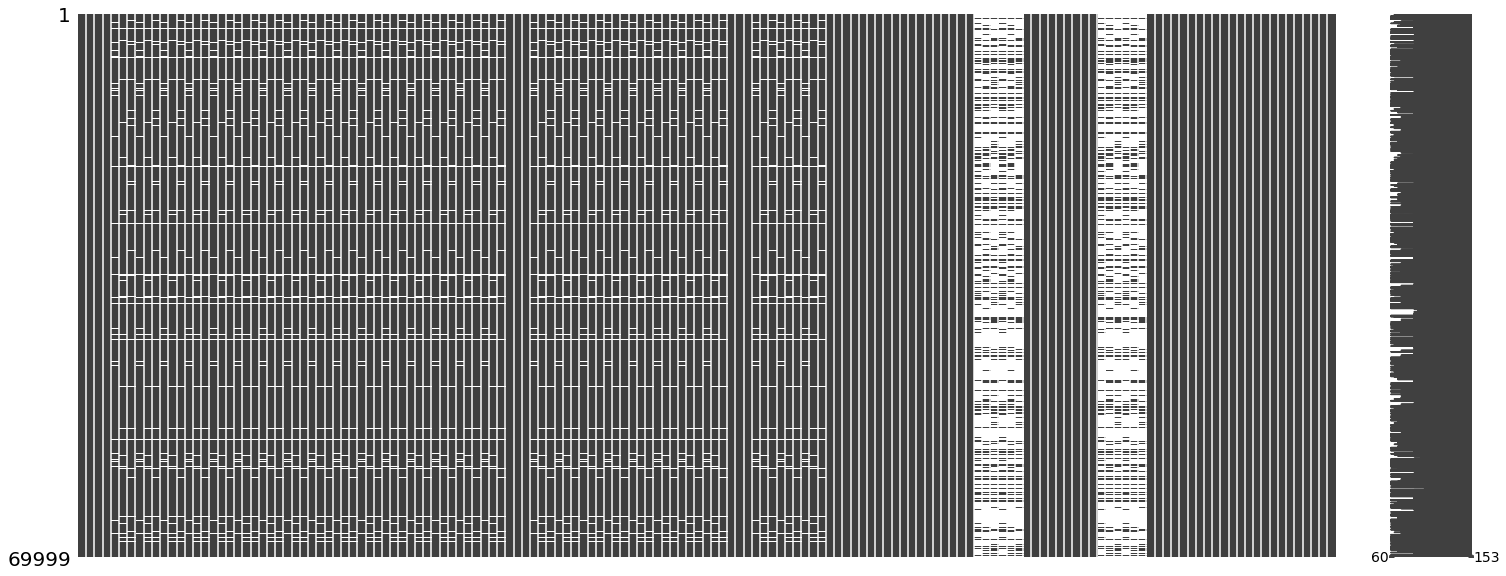

In [558]:
#msno.bar(data)
msno.matrix(data)


In [559]:

missing_data_percent = 100*data.isnull().sum()/len(data)
missing_data_percent


id                   0.000000
arpu_6               0.000000
arpu_7               0.000000
arpu_8               0.000000
onnet_mou_6          3.954342
                       ...   
aon                  0.000000
aug_vbc_3g           0.000000
jul_vbc_3g           0.000000
jun_vbc_3g           0.000000
churn_probability    0.000000
Length: 153, dtype: float64

In [560]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=141)

In [561]:
data = data[new_vars]
data.shape
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 141 columns):
 #    Column              Dtype  
---   ------              -----  
 0    id                  int64  
 1    arpu_6              float64
 2    arpu_7              float64
 3    arpu_8              float64
 4    onnet_mou_6         float64
 5    onnet_mou_7         float64
 6    onnet_mou_8         float64
 7    offnet_mou_6        float64
 8    offnet_mou_7        float64
 9    offnet_mou_8        float64
 10   roam_ic_mou_6       float64
 11   roam_ic_mou_7       float64
 12   roam_ic_mou_8       float64
 13   roam_og_mou_6       float64
 14   roam_og_mou_7       float64
 15   roam_og_mou_8       float64
 16   loc_og_t2t_mou_6    float64
 17   loc_og_t2t_mou_7    float64
 18   loc_og_t2t_mou_8    float64
 19   loc_og_t2m_mou_6    float64
 20   loc_og_t2m_mou_7    float64
 21   loc_og_t2m_mou_8    float64
 22   loc_og_t2f_mou_6    float64
 23   loc_og_t2f_mou_7    float64
 24   

In [562]:
new_vars1=new_vars.delete(-1)
unseen = unseen[new_vars1]
unseen.shape

(30000, 140)

Impute using simple imputer- fill with zero

In [563]:
missing_data_percent = data.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols
imp = SimpleImputer(strategy='constant', fill_value=0)
data[impute_cols] = imp.fit_transform(data[impute_cols])

In [564]:
data.shape

(69999, 141)

filter high-value customers
calculate total data recharge amount

In [565]:
# let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
data['total_rech_amt_data_6'] = data.av_rech_amt_data_6 * data.total_rech_data_6
data['total_rech_amt_data_7'] = data.av_rech_amt_data_7 * data.total_rech_data_7
data['total_rech_amt_data_8'] = data.av_rech_amt_data_8 * data.total_rech_data_8

In [566]:
data['total_avg_rech_amnt_6_7_GPhase'] = (data.total_rech_amt_6 + data.total_rech_amt_data_6 )/2

In [567]:
#unseen['total_avg_rech_amnt_6_7_GPhase'] = (unseen.total_rech_amt_6 + unseen.total_rech_amt_data_6 )/2

In [568]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = data.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)

print('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter))

data = data[data.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
print('Dataframe Shape after Filtering High Value Customers: ' + str(data.shape))

70 percentile of 6th and 7th months avg recharge amount: 238.0
Dataframe Shape after Filtering High Value Customers: (20994, 145)


In [569]:
#3. Tag churners and remove attributes of the churn phase
high_val_cust_8 = ['total_ic_mou_8', 'total_og_mou_8', 'vol_2g_mb_8','vol_3g_mb_8']


In [570]:
# Checking the NA/Null values are present or Not
df = 100*data.loc[:,high_val_cust_8].isnull().sum()/len(data)
df = pd.DataFrame(df)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage)
display(df)

,Null_Percentage
total_ic_mou_8,0.0
total_og_mou_8,0.0
vol_2g_mb_8,0.0
vol_3g_mb_8,0.0


In [571]:
# Initially set all the values as 0
data['churn']= 0

In [572]:
#is_churned boolean flag for customers where above values are zero
is_churned = (data.total_ic_mou_8 == 0) & \
             (data.total_og_mou_8 == 0) & \
             (data.vol_2g_mb_8 ==0) & \
             (data.vol_3g_mb_8 ==0)

In [573]:
# set all which having is_churned True condition as 1
data.loc[is_churned,'churn']=1

In [574]:
# let us check what's the % of churned customers
100*data.churn.sum()/len(data)

8.426217014385063

In [575]:
churn_month_columns =  data.columns[data.columns.str.contains('_8')]

In [576]:
churn_month_columns1 =  unseen.columns[unseen.columns.str.contains('_8')]

In [577]:
# drop all columns corresponding to the churn phase
data.drop(churn_month_columns,axis=1,inplace=True)
data.shape
unseen.drop(churn_month_columns1,axis=1,inplace=True)
unseen.shape

(30000, 95)

In [578]:
data.shape

(20994, 100)

In [579]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20994 entries, 4 to 69997
Data columns (total 100 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20994 non-null  int64  
 1   arpu_6                          20994 non-null  float64
 2   arpu_7                          20994 non-null  float64
 3   onnet_mou_6                     20994 non-null  float64
 4   onnet_mou_7                     20994 non-null  float64
 5   offnet_mou_6                    20994 non-null  float64
 6   offnet_mou_7                    20994 non-null  float64
 7   roam_ic_mou_6                   20994 non-null  float64
 8   roam_ic_mou_7                   20994 non-null  float64
 9   roam_og_mou_6                   20994 non-null  float64
 10  roam_og_mou_7                   20994 non-null  float64
 11  loc_og_t2t_mou_6                20994 non-null  float64
 12  loc_og_t2t_mou_7               

# Visualize the data

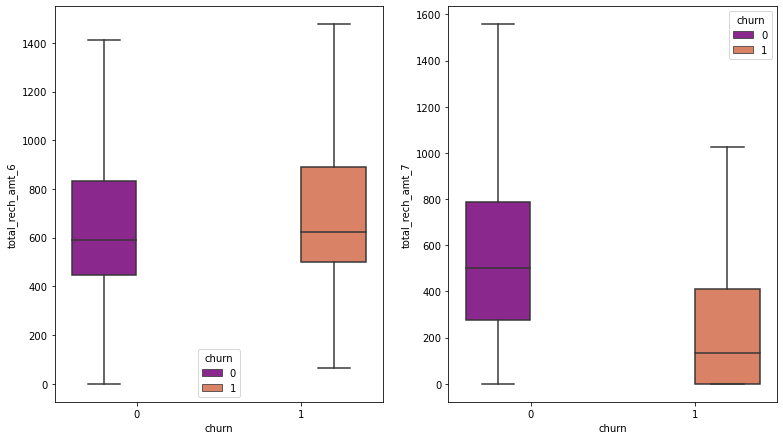

In [580]:
# Ploting for total recharge amount:

plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="total_rech_amt_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="total_rech_amt_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))


plt.show()

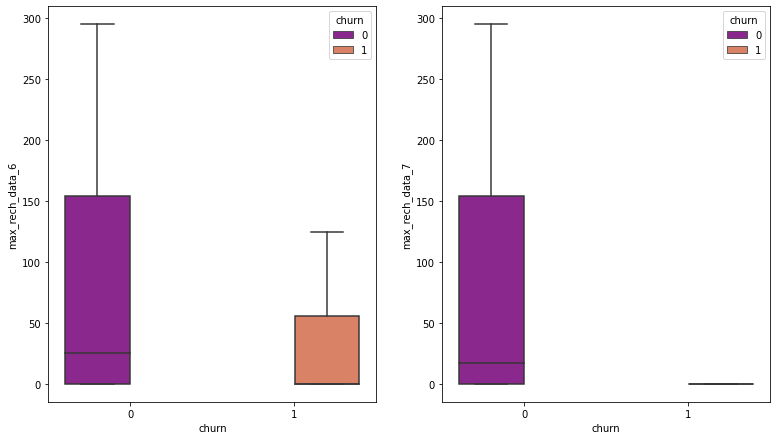

In [581]:
# Ploting for maximum recharge amount for data:
plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="max_rech_data_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="max_rech_data_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))


plt.show()

we can see that there is no drop in customer in month 7

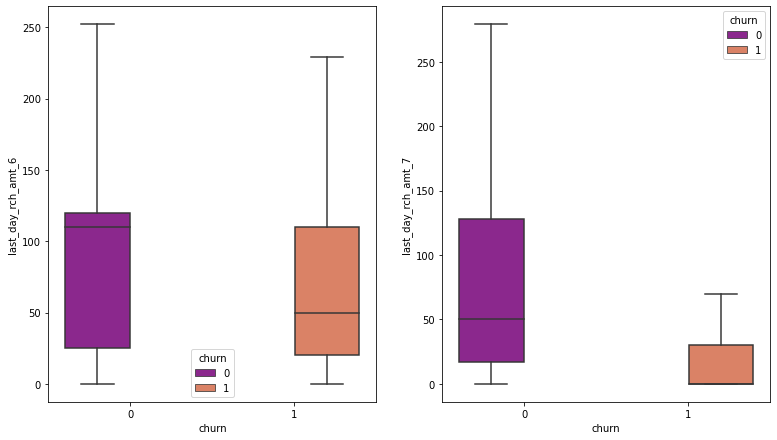

In [582]:
# Ploting for last day recharge amount:

plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="last_day_rch_amt_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="last_day_rch_amt_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))


plt.show()


Analysis: We are getting a huge drop in 7th month recharge amount for churned customers.

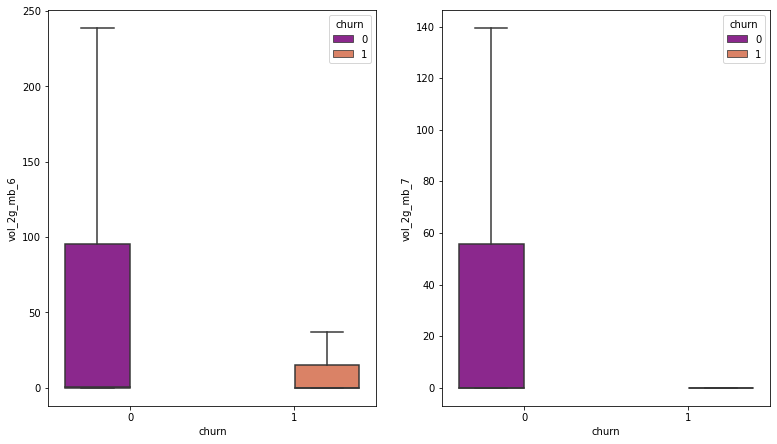

In [583]:
# Ploting for volume of 2G and 3G usage columns:

plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="vol_2g_mb_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="vol_2g_mb_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))


plt.show()

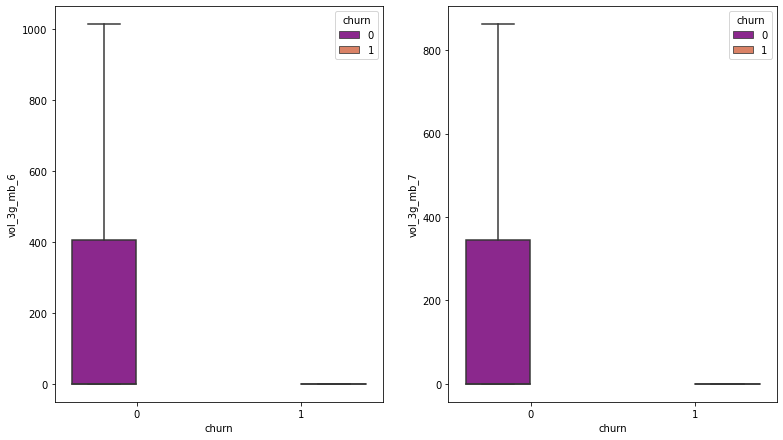

In [584]:
# Ploting for volume of 2G and 3G usage columns:

plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="vol_3g_mb_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="vol_3g_mb_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))

plt.show()

**Analysis:** 
1) 2G and 3G usage for churned customers drops in 7th month and 3 G usage for churned customer drops in month 8.
2) We also see that 2G/3G usage is higher for non-churned customers indicating that churned customers might be from areas where 2G/3G service is not properly available.

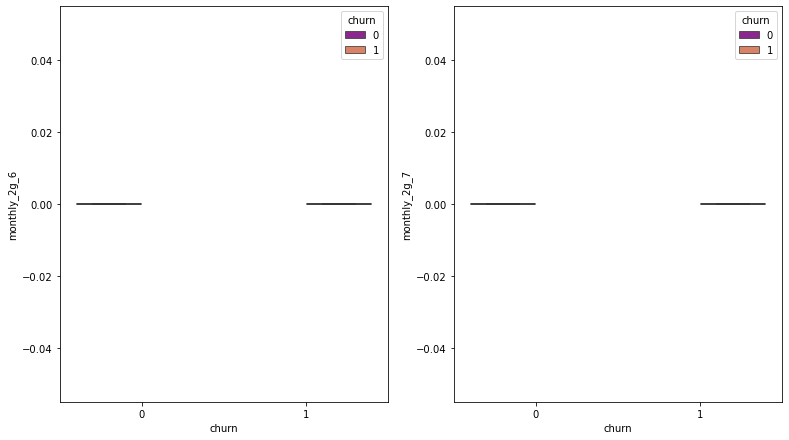

In [585]:
    
# Ploting for volume of monthly columns:

plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="monthly_2g_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="monthly_2g_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))

plt.show()

Value range is very low, hence graph is not giving us proper justification result 

In [586]:
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

In [587]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = data.columns[data.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g.tolist()

['monthly_2g_6', 'monthly_2g_7', 'monthly_3g_6', 'monthly_3g_7']

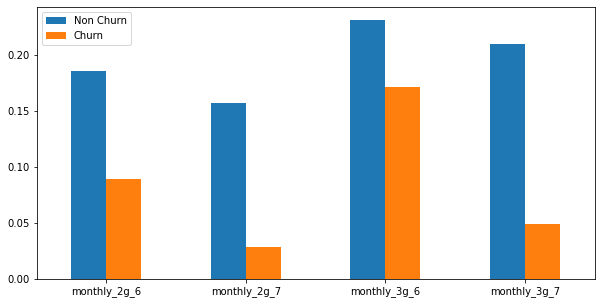

,monthly_2g_6,monthly_2g_7,monthly_3g_6,monthly_3g_7
Non Churn,0.185852,0.156983,0.231469,0.210351
Churn,0.089316,0.028265,0.171283,0.049180


In [588]:
plot_mean_bar_chart(data, monthly_subcription_2g_3g)

There is a drop in churn in 7 th month

In [589]:
# Minutes of usage - voice calls
mou_cols = data.columns[data.columns.str.contains('mou')]

In [590]:
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7',
       'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6', 'isd_og_mou_7',
       'spl_og_mou_6', 'spl_og_mou_7', 'total_og_mou_6', 'total_og_mou_7',
       'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7',
       'loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_6',
      

In [591]:
def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 

def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix

In [592]:
meta_df = get_meta_data(data[mou_cols])
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
onnet_mou_6,0.0
std_ic_t2t_mou_6,0.0
spl_og_mou_7,0.0
total_og_mou_6,0.0
total_og_mou_7,0.0
loc_ic_t2t_mou_6,0.0
loc_ic_t2t_mou_7,0.0
loc_ic_t2m_mou_6,0.0
loc_ic_t2m_mou_7,0.0
loc_ic_t2f_mou_6,0.0


In [593]:
def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

In [594]:
mou_og_cols6 = data.columns[data.columns.str.contains('.*_og_.*mou_6',regex=True)]


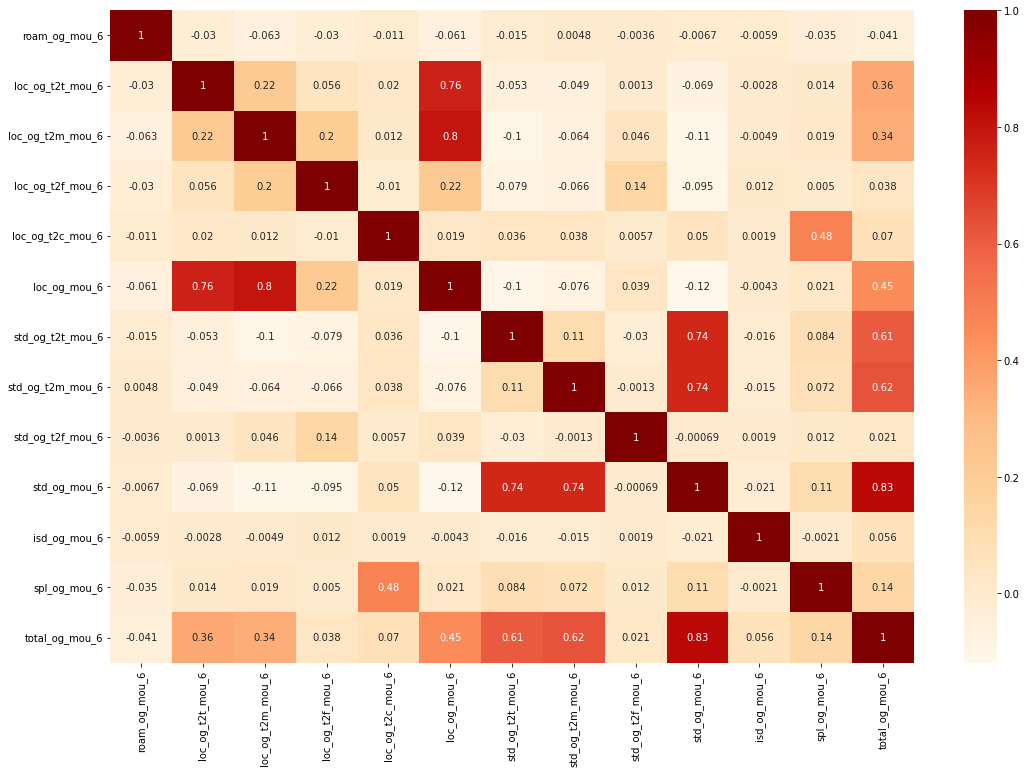

In [595]:
heatmap(18,12,data.filter(mou_og_cols6))

We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [596]:
data['total_ABC'] = data[["loc_og_mou_6", "std_og_mou_6", "spl_og_mou_6","isd_og_mou_6","og_others_6"]].sum(axis=1)
print(data['total_ABC'])

4          63.26
10        101.05
12        816.44
14        228.66
15        327.64
          ...   
69981    1104.47
69984     916.77
69993     156.79
69996     412.66
69997      39.78
Name: total_ABC, Length: 20994, dtype: float64


In [597]:
print(data['total_og_mou_6'])

4          63.26
10        101.06
12        816.44
14        228.68
15        327.64
          ...   
69981    1104.48
69984     916.79
69993     156.81
69996     412.68
69997      39.78
Name: total_og_mou_6, Length: 20994, dtype: float64


We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [598]:
list_total_og_cols = data.columns[data.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
data.drop(list_total_og_cols,axis=1,inplace=True)
print("Columns dropped - ")
list_total_og_cols.tolist()

Columns dropped - 


['loc_og_mou_6',
 'loc_og_mou_7',
 'std_og_mou_6',
 'std_og_mou_7',
 'total_og_mou_6',
 'total_og_mou_7']

In [599]:
data.drop('total_ABC',axis=1,inplace=True)

In [600]:
data.shape

(20994, 94)

Check for incoming calls

In [601]:
mou_ic_cols6 = data.columns[data.columns.str.contains('.*_ic_.*mou_6',regex=True)]

In [602]:
mou_ic_cols6

Index(['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6',
       'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

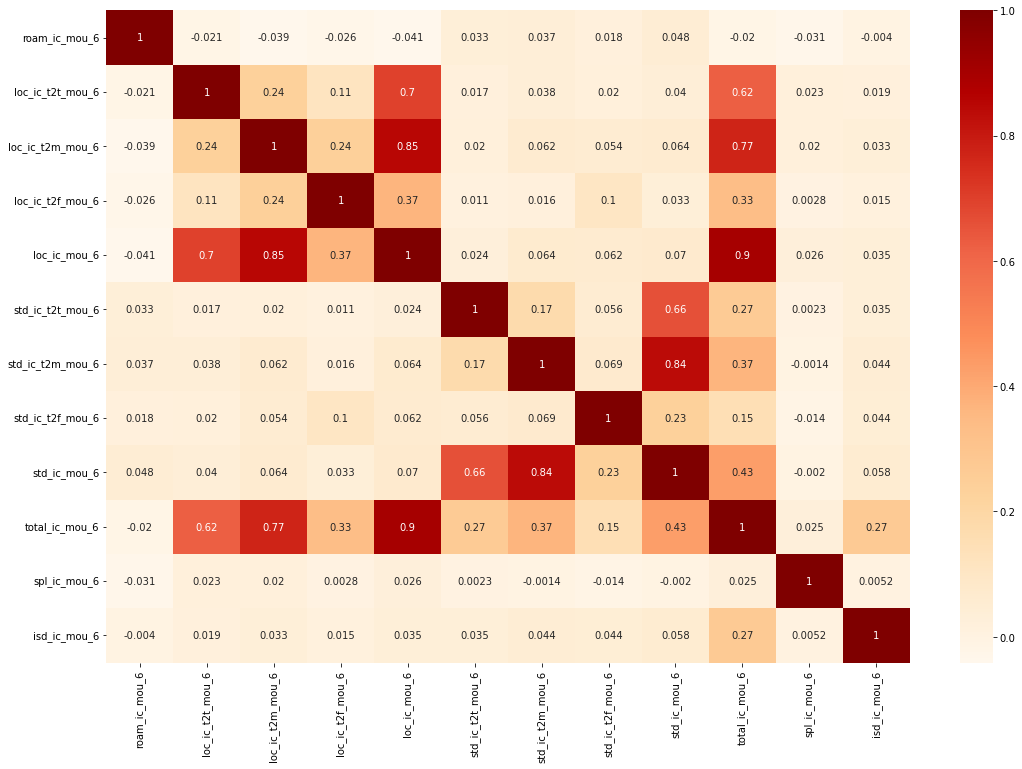

In [603]:
heatmap(18,12,data.filter(mou_ic_cols6))

We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [604]:
data['total_ABC'] =data[['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum(axis=1)

print(data['total_ABC'])

4         21.53
10       140.68
12        26.93
14       289.09
15       233.17
          ...  
69981    435.85
69984    324.36
69993     20.23
69996    529.46
69997     12.36
Name: total_ABC, Length: 20994, dtype: float64


In [605]:
print(data['loc_ic_mou_6'])

4         21.54
10       140.69
12        26.93
14       289.09
15       233.18
          ...  
69981    435.86
69984    324.38
69993     20.24
69996    529.48
69997     12.38
Name: loc_ic_mou_6, Length: 20994, dtype: float64


We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [606]:
list_total_ic_cols = data.columns[data.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
data.drop(list_total_ic_cols,axis=1,inplace=True)
print("Columns dropped - ")
print(list_total_ic_cols.tolist())

Columns dropped - 
['loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_6', 'total_ic_mou_7']


In [607]:
print(data.shape)

(20994, 89)


In [608]:
data.drop('total_ABC',axis=1,inplace=True)

In [609]:
print(data.shape)

(20994, 88)


In [610]:
list_total_og_cols1 = unseen.columns[unseen.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
unseen.drop(list_total_og_cols1,axis=1,inplace=True)
print("Columns dropped - ")
list_total_og_cols1.tolist()

Columns dropped - 


['loc_og_mou_6',
 'loc_og_mou_7',
 'std_og_mou_6',
 'std_og_mou_7',
 'total_og_mou_6',
 'total_og_mou_7']

In [611]:
list_total_ic_cols1 = unseen.columns[unseen.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
unseen.drop(list_total_ic_cols1,axis=1,inplace=True)
print("Columns dropped - ")
print(list_total_ic_cols1.tolist())

Columns dropped - 
['loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_6', 'total_ic_mou_7']


In [612]:
print(unseen.shape)

(30000, 83)


Offnet Usage

In [613]:
offnet_usage_service_col = data.columns[data.columns.str.contains('offnet.*mou',regex=True)]

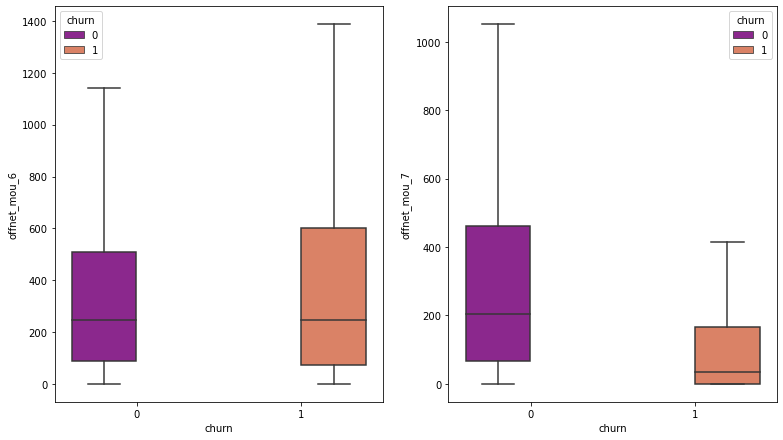

In [614]:
plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="offnet_mou_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="offnet_mou_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))

plt.show()

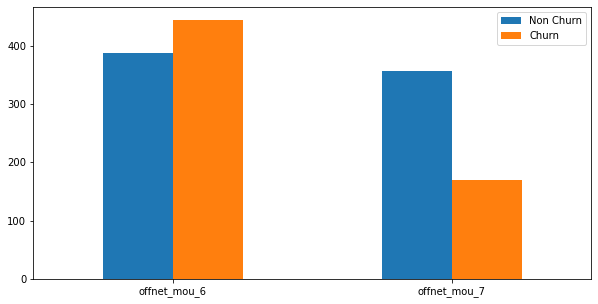

,offnet_mou_6,offnet_mou_7
Non Churn,387.818554,357.174877
Churn,444.221583,169.825461


In [615]:
plot_mean_bar_chart(data, offnet_usage_service_col)

We can see the drop for offnet mou services in the 7th month

 ONNET : All kind of calls within the same operator network

In [616]:
#minutes of usage related columns
onnet_usage_service =  data.columns[data.columns.str.contains('^onnet.*mou',regex=True)]

In [617]:
onnet_usage_service

Index(['onnet_mou_6', 'onnet_mou_7'], dtype='object')

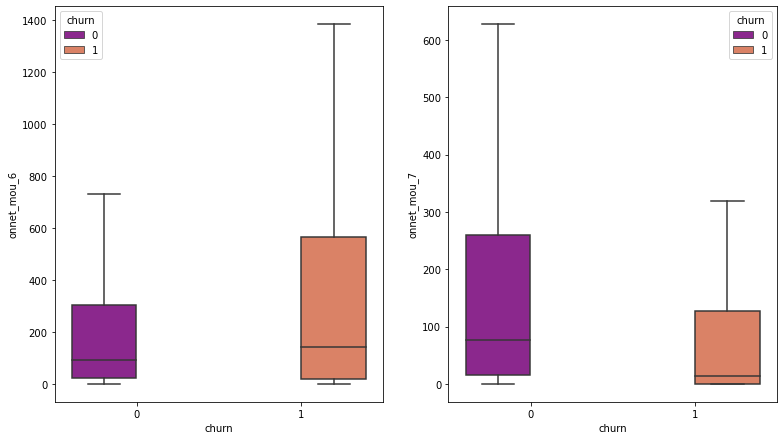

In [618]:
plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="onnet_mou_6",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="onnet_mou_7",x="churn",hue="churn",
            showfliers=False,palette=("plasma"))

plt.show()

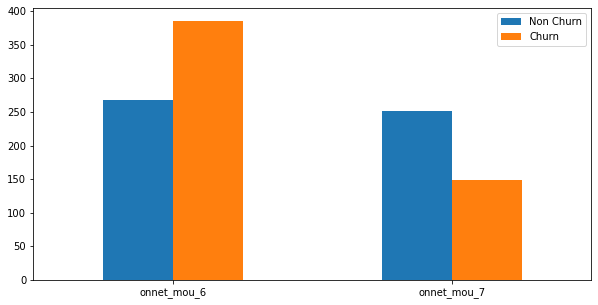

,onnet_mou_6,onnet_mou_7
Non Churn,268.201099,250.911664
Churn,385.279129,148.850119


In [619]:
plot_mean_bar_chart(data, onnet_usage_service)

We also see that there is a drop in Onnet usage in the 7th month for churned customers

Tenure Analysis for Customers

In [620]:
tenure_data = data.copy()

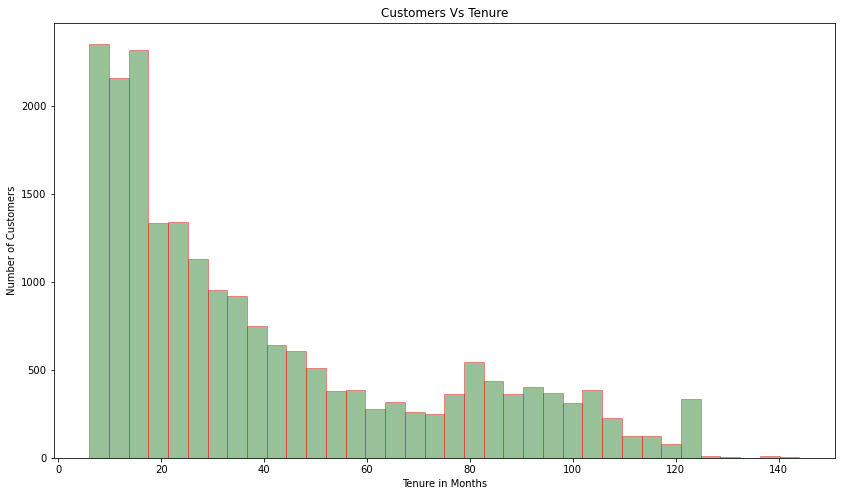

In [621]:
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [622]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

4         1-2 Yrs
10        1-2 Yrs
12    6-12 Months
14        2-5 Yrs
15        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

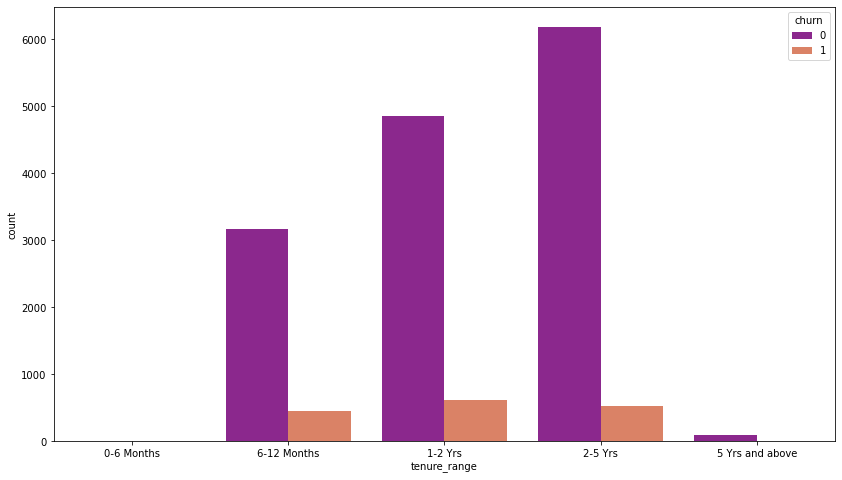

In [623]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("plasma"))
plt.show()

customers using for 5 years have no churn customer

In [624]:
data.drop('total_avg_rech_amnt_6_7_GPhase',axis=1,inplace=True)

In [625]:
data.shape

(20994, 87)

In [626]:
data.info(verbose=all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20994 entries, 4 to 69997
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20994 non-null  int64  
 1   arpu_6                 20994 non-null  float64
 2   arpu_7                 20994 non-null  float64
 3   onnet_mou_6            20994 non-null  float64
 4   onnet_mou_7            20994 non-null  float64
 5   offnet_mou_6           20994 non-null  float64
 6   offnet_mou_7           20994 non-null  float64
 7   roam_ic_mou_6          20994 non-null  float64
 8   roam_ic_mou_7          20994 non-null  float64
 9   roam_og_mou_6          20994 non-null  float64
 10  roam_og_mou_7          20994 non-null  float64
 11  loc_og_t2t_mou_6       20994 non-null  float64
 12  loc_og_t2t_mou_7       20994 non-null  float64
 13  loc_og_t2m_mou_6       20994 non-null  float64
 14  loc_og_t2m_mou_7       20994 non-null  float64
 15  lo

In [627]:
unseen.info(verbose=all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 83 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  30000 non-null  int64  
 1   arpu_6              30000 non-null  float64
 2   arpu_7              30000 non-null  float64
 3   onnet_mou_6         28831 non-null  float64
 4   onnet_mou_7         28828 non-null  float64
 5   offnet_mou_6        28831 non-null  float64
 6   offnet_mou_7        28828 non-null  float64
 7   roam_ic_mou_6       28831 non-null  float64
 8   roam_ic_mou_7       28828 non-null  float64
 9   roam_og_mou_6       28831 non-null  float64
 10  roam_og_mou_7       28828 non-null  float64
 11  loc_og_t2t_mou_6    28831 non-null  float64
 12  loc_og_t2t_mou_7    28828 non-null  float64
 13  loc_og_t2m_mou_6    28831 non-null  float64
 14  loc_og_t2m_mou_7    28828 non-null  float64
 15  loc_og_t2f_mou_6    28831 non-null  float64
 16  loc_

In [628]:
uc=['total_rech_amt_data_6','total_rech_amt_data_7','churn']
data.drop(labels=uc,axis=1,inplace=True)


In [629]:
col_list = data.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    data[avg_col_name] = (data[col_6]  + data[col_7])/ 2

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
night_pck_user
monthly_2g
sachet_2g
monthly_3g
sachet_3g
fb_user


In [630]:
col_list_to_drop = data.filter(regex='_6|_7')
data.drop(col_list_to_drop,axis=1,inplace=True)
print (data.shape)

(20994, 45)


In [631]:
col_list1 = unseen.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list1.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    unseen[avg_col_name] = (unseen[col_6]  + unseen[col_7])/ 2

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
night_pck_user
monthly_2g
sachet_2g
monthly_3g
sachet_3g
fb_user


In [632]:
col_list_to_drop1 = unseen.filter(regex='_6|_7')
unseen.drop(col_list_to_drop1,axis=1,inplace=True)
print (unseen.shape)

(30000, 44)


We have merged most of the columns related to month 6 & 7 so to reduce the number of features. By doing this apporach we have reduced the fetures from 128 to 48

Removing Outliers

In [633]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [634]:
# example of capping
sample_array = list(range(100))

# add outliers to the data
sample_array[0] = -9999
sample_array[99] = 9999

# cap outliers
sample_array = np.array(sample_array)
print("Array after capping outliers: \n", cap_outliers(sample_array, k=2))

Array after capping outliers: 
 [-2780     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  2877]


In [635]:
num_cols = [column for column in data.columns if column not in id_cols + date_cols + cat_cols]
num_cols

['id',
 'aon',
 'aug_vbc_3g',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'churn_probability',
 'avg_arpu_av67',
 'avg_onnet_mou_av67',
 'avg_offnet_mou_av67',
 'avg_roam_ic_mou_av67',
 'avg_roam_og_mou_av67',
 'avg_loc_og_t2t_mou_av67',
 'avg_loc_og_t2m_mou_av67',
 'avg_loc_og_t2f_mou_av67',
 'avg_loc_og_t2c_mou_av67',
 'avg_std_og_t2t_mou_av67',
 'avg_std_og_t2m_mou_av67',
 'avg_std_og_t2f_mou_av67',
 'avg_isd_og_mou_av67',
 'avg_spl_og_mou_av67',
 'avg_og_others_av67',
 'avg_loc_ic_t2t_mou_av67',
 'avg_loc_ic_t2m_mou_av67',
 'avg_loc_ic_t2f_mou_av67',
 'avg_std_ic_t2t_mou_av67',
 'avg_std_ic_t2m_mou_av67',
 'avg_std_ic_t2f_mou_av67',
 'avg_spl_ic_mou_av67',
 'avg_isd_ic_mou_av67',
 'avg_ic_others_av67',
 'avg_total_rech_num_av67',
 'avg_total_rech_amt_av67',
 'avg_max_rech_amt_av67',
 'avg_last_day_rch_amt_av67',
 'avg_total_rech_data_av67',
 'avg_max_rech_data_av67',
 'avg_av_rech_amt_data_av67',
 'avg_vol_2g_mb_av67',
 'avg_vol_3g_mb_av67',
 'avg_night_pck_user_av67',
 'avg_monthly_2g_av67',
 

In [636]:
# cap outliers in the numeric columns
data[num_cols] = data[num_cols].apply(cap_outliers, axis=0)

In [637]:
num_cols

['id',
 'aon',
 'aug_vbc_3g',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'churn_probability',
 'avg_arpu_av67',
 'avg_onnet_mou_av67',
 'avg_offnet_mou_av67',
 'avg_roam_ic_mou_av67',
 'avg_roam_og_mou_av67',
 'avg_loc_og_t2t_mou_av67',
 'avg_loc_og_t2m_mou_av67',
 'avg_loc_og_t2f_mou_av67',
 'avg_loc_og_t2c_mou_av67',
 'avg_std_og_t2t_mou_av67',
 'avg_std_og_t2m_mou_av67',
 'avg_std_og_t2f_mou_av67',
 'avg_isd_og_mou_av67',
 'avg_spl_og_mou_av67',
 'avg_og_others_av67',
 'avg_loc_ic_t2t_mou_av67',
 'avg_loc_ic_t2m_mou_av67',
 'avg_loc_ic_t2f_mou_av67',
 'avg_std_ic_t2t_mou_av67',
 'avg_std_ic_t2m_mou_av67',
 'avg_std_ic_t2f_mou_av67',
 'avg_spl_ic_mou_av67',
 'avg_isd_ic_mou_av67',
 'avg_ic_others_av67',
 'avg_total_rech_num_av67',
 'avg_total_rech_amt_av67',
 'avg_max_rech_amt_av67',
 'avg_last_day_rch_amt_av67',
 'avg_total_rech_data_av67',
 'avg_max_rech_data_av67',
 'avg_av_rech_amt_data_av67',
 'avg_vol_2g_mb_av67',
 'avg_vol_3g_mb_av67',
 'avg_night_pck_user_av67',
 'avg_monthly_2g_av67',
 

# Modelling

In [638]:
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [639]:
data.info(verbose=all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20994 entries, 4 to 69997
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         20994 non-null  int64  
 1   aon                        20994 non-null  float64
 2   aug_vbc_3g                 20994 non-null  float64
 3   jul_vbc_3g                 20994 non-null  float64
 4   jun_vbc_3g                 20994 non-null  float64
 5   churn_probability          20994 non-null  int64  
 6   avg_arpu_av67              20994 non-null  float64
 7   avg_onnet_mou_av67         20994 non-null  float64
 8   avg_offnet_mou_av67        20994 non-null  float64
 9   avg_roam_ic_mou_av67       20994 non-null  float64
 10  avg_roam_og_mou_av67       20994 non-null  float64
 11  avg_loc_og_t2t_mou_av67    20994 non-null  float64
 12  avg_loc_og_t2m_mou_av67    20994 non-null  float64
 13  avg_loc_og_t2f_mou_av67    20994 non-null  flo

In [640]:
# divide data into train and test
X = data.drop("churn_probability", axis = 1)
y = data.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)


In [641]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16795, 44), (4199, 44), (16795,), (4199,))

In [642]:
newvars=X_train.columns.values.tolist()
print(newvars)

['id', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67', 'avg_loc_og_t2f_mou_av67', 'avg_loc_og_t2c_mou_av67', 'avg_std_og_t2t_mou_av67', 'avg_std_og_t2m_mou_av67', 'avg_std_og_t2f_mou_av67', 'avg_isd_og_mou_av67', 'avg_spl_og_mou_av67', 'avg_og_others_av67', 'avg_loc_ic_t2t_mou_av67', 'avg_loc_ic_t2m_mou_av67', 'avg_loc_ic_t2f_mou_av67', 'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67', 'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67', 'avg_ic_others_av67', 'avg_total_rech_num_av67', 'avg_total_rech_amt_av67', 'avg_max_rech_amt_av67', 'avg_last_day_rch_amt_av67', 'avg_total_rech_data_av67', 'avg_max_rech_data_av67', 'avg_av_rech_amt_data_av67', 'avg_vol_2g_mb_av67', 'avg_vol_3g_mb_av67', 'avg_night_pck_user_av67', 'avg_monthly_2g_av67', 'avg_sachet_2g_av67', 'avg_monthly_3g_av67', 'avg_sachet_3g_av

In [643]:
#feature Scaling
scale = StandardScaler()
data = scale.fit_transform(data)

<AxesSubplot:>

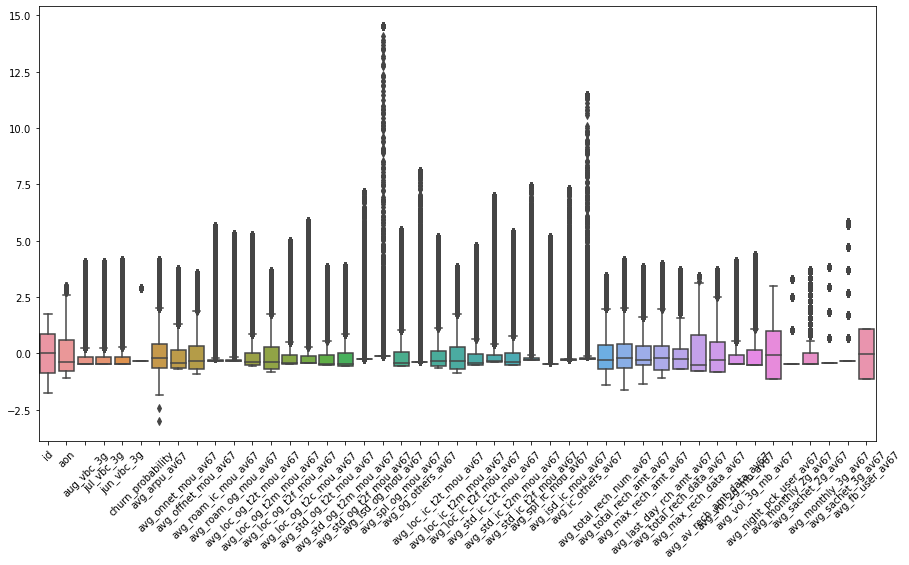

In [644]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(data, columns=num_cols))

<AxesSubplot:>

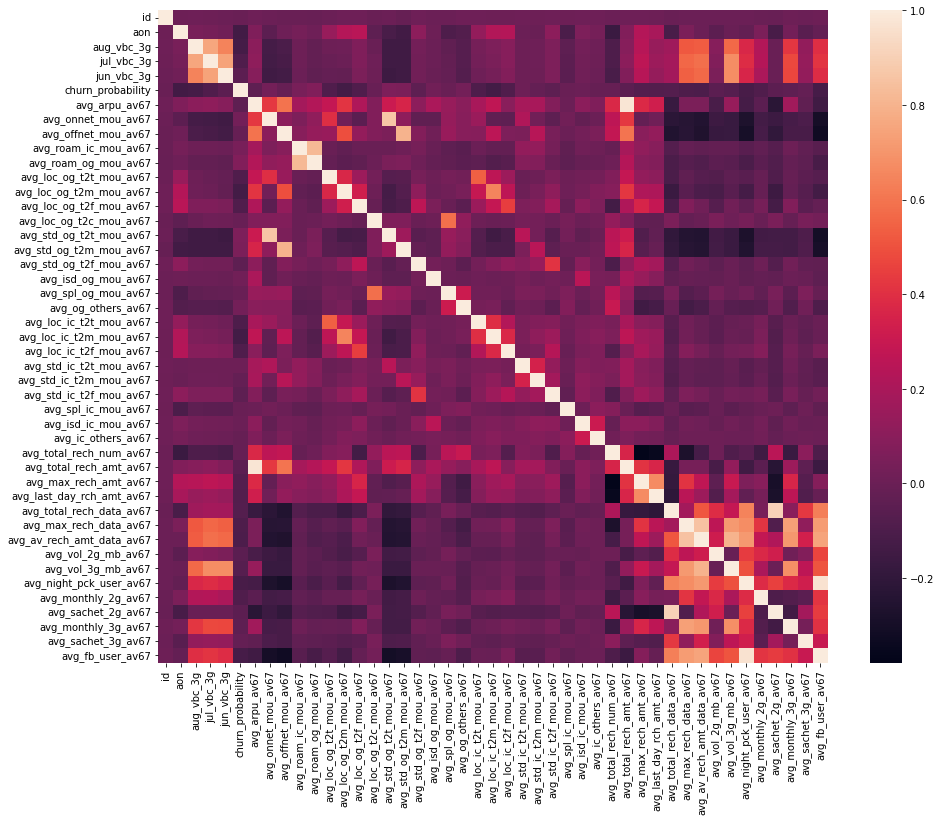

In [645]:
plt.figure(figsize=(15,12))
sns.heatmap(pd.DataFrame(data, columns=num_cols).corr())

<AxesSubplot:xlabel='churn_probability', ylabel='Count'>

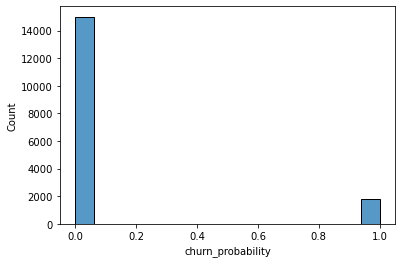

In [646]:
sns.histplot(y_train)

# Modelling
# PCA : Principal Component Analysis

In [647]:
telecom_pca_df = data.copy()

In [648]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [649]:

pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)


In [650]:
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [651]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0      15.77
1      27.16
2      34.08
3      40.00
4      44.35
5      48.36
6      52.11
7      55.42
8      58.63
9      61.66
10     64.68
11     67.12
12     69.45
13     71.73
14     73.99
15     76.15
16     78.19
17     80.13
18     81.94
19     83.71
20     85.39
21     86.87
22     88.25
23     89.53
24     90.80
25     91.96
26     93.02
27     94.03
28     94.89
29     95.74
30     96.44
31     97.11
32     97.77
33     98.25
34     98.71
35     99.09
36     99.41
37     99.67
38     99.77
39     99.84
40     99.89
41     99.93
42     99.97
43    100.00
dtype: float64


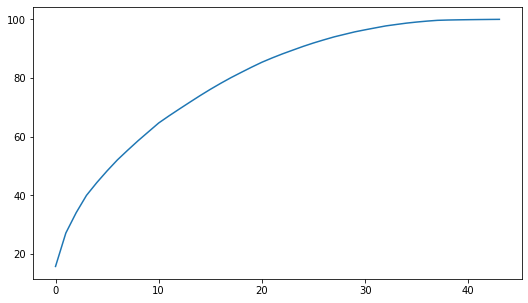

In [652]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

# PCA and Logistic Regression

In [653]:
# create pipeline
PCA_VARS = 44
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)


In [654]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.6516225066984221

Evaluate on test data

In [655]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[2374 1359]
 [ 102  364]]
Sensitivity: 	0.78
Specificity: 	0.64
AUC:    	 0.78


Creating submission file

In [656]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [657]:
unseen.head()

,id,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_night_pck_user_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_fb_user_av67
0,69999,1692,0.00,0.00,0.00,78.6060,26.005,46.160,0.000,0.000,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
1,70000,2533,0.00,0.00,0.00,464.8680,58.360,548.090,0.000,0.000,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,70001,277,525.61,758.41,241.84,382.3640,7.700,31.395,63.095,39.105,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,70002,1244,0.00,0.00,0.00,107.4700,3.735,122.525,0.000,0.000,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
4,70003,462,0.00,0.00,0.00,356.5715,529.980,42.390,0.000,0.000,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [658]:
newvars=unseen.columns

In [659]:
print(newvars)

Index(['id', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'avg_arpu_av67',
       'avg_onnet_mou_av67', 'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67',
       'avg_roam_og_mou_av67', 'avg_loc_og_t2t_mou_av67',
       'avg_loc_og_t2m_mou_av67', 'avg_loc_og_t2f_mou_av67',
       'avg_loc_og_t2c_mou_av67', 'avg_std_og_t2t_mou_av67',
       'avg_std_og_t2m_mou_av67', 'avg_std_og_t2f_mou_av67',
       'avg_isd_og_mou_av67', 'avg_spl_og_mou_av67', 'avg_og_others_av67',
       'avg_loc_ic_t2t_mou_av67', 'avg_loc_ic_t2m_mou_av67',
       'avg_loc_ic_t2f_mou_av67', 'avg_std_ic_t2t_mou_av67',
       'avg_std_ic_t2m_mou_av67', 'avg_std_ic_t2f_mou_av67',
       'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67', 'avg_ic_others_av67',
       'avg_total_rech_num_av67', 'avg_total_rech_amt_av67',
       'avg_max_rech_amt_av67', 'avg_last_day_rch_amt_av67',
       'avg_total_rech_data_av67', 'avg_max_rech_data_av67',
       'avg_av_rech_amt_data_av67', 'avg_vol_2g_mb_av67', 'avg_vol_3g_mb_av67',
       '

In [660]:
unseen.info(verbose=all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         30000 non-null  int64  
 1   aon                        30000 non-null  int64  
 2   aug_vbc_3g                 30000 non-null  float64
 3   jul_vbc_3g                 30000 non-null  float64
 4   jun_vbc_3g                 30000 non-null  float64
 5   avg_arpu_av67              30000 non-null  float64
 6   avg_onnet_mou_av67         28208 non-null  float64
 7   avg_offnet_mou_av67        28208 non-null  float64
 8   avg_roam_ic_mou_av67       28208 non-null  float64
 9   avg_roam_og_mou_av67       28208 non-null  float64
 10  avg_loc_og_t2t_mou_av67    28208 non-null  float64
 11  avg_loc_og_t2m_mou_av67    28208 non-null  float64
 12  avg_loc_og_t2f_mou_av67    28208 non-null  float64
 13  avg_loc_og_t2c_mou_av67    28208 non-null  flo

In [661]:
unseen.shape


(30000, 44)

In [662]:
unseen.info(verbose=all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         30000 non-null  int64  
 1   aon                        30000 non-null  int64  
 2   aug_vbc_3g                 30000 non-null  float64
 3   jul_vbc_3g                 30000 non-null  float64
 4   jun_vbc_3g                 30000 non-null  float64
 5   avg_arpu_av67              30000 non-null  float64
 6   avg_onnet_mou_av67         28208 non-null  float64
 7   avg_offnet_mou_av67        28208 non-null  float64
 8   avg_roam_ic_mou_av67       28208 non-null  float64
 9   avg_roam_og_mou_av67       28208 non-null  float64
 10  avg_loc_og_t2t_mou_av67    28208 non-null  float64
 11  avg_loc_og_t2m_mou_av67    28208 non-null  float64
 12  avg_loc_og_t2f_mou_av67    28208 non-null  float64
 13  avg_loc_og_t2c_mou_av67    28208 non-null  flo

In [663]:
#unseen.drop('id',axis=1,inplace=True)

In [664]:
newvars=unseen.columns.tolist()
print(newvars)

['id', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67', 'avg_loc_og_t2f_mou_av67', 'avg_loc_og_t2c_mou_av67', 'avg_std_og_t2t_mou_av67', 'avg_std_og_t2m_mou_av67', 'avg_std_og_t2f_mou_av67', 'avg_isd_og_mou_av67', 'avg_spl_og_mou_av67', 'avg_og_others_av67', 'avg_loc_ic_t2t_mou_av67', 'avg_loc_ic_t2m_mou_av67', 'avg_loc_ic_t2f_mou_av67', 'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67', 'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67', 'avg_ic_others_av67', 'avg_total_rech_num_av67', 'avg_total_rech_amt_av67', 'avg_max_rech_amt_av67', 'avg_last_day_rch_amt_av67', 'avg_total_rech_data_av67', 'avg_max_rech_data_av67', 'avg_av_rech_amt_data_av67', 'avg_vol_2g_mb_av67', 'avg_vol_3g_mb_av67', 'avg_night_pck_user_av67', 'avg_monthly_2g_av67', 'avg_sachet_2g_av67', 'avg_monthly_3g_av67', 'avg_sachet_3g_av

In [665]:
#submission_data = unseen.set_index('id')[newvars]
#submission_data.shape

In [666]:
missing_data_percent = unseen.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols
imp = SimpleImputer(strategy='constant', fill_value=0)
unseen[impute_cols] = imp.fit_transform(unseen[impute_cols])

In [667]:
missing_data_percent = unseen.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index([], dtype='object')

In [668]:
unseen['churn_probability'] = pipeline.predict(unseen)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,1
1,70000,0
2,70001,0
3,70002,0
4,70003,1


In [669]:
output.to_csv('submission.csv',index=False)